In [31]:
# Model Evaluation for Spending Cluster Prediction
# Compares Logistic Regression and Random Forest across multiple feature sets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib
import os


In [32]:
# 1. Load Data

df = pd.read_csv('../featured_customer_segmentation_with_clusters.csv')


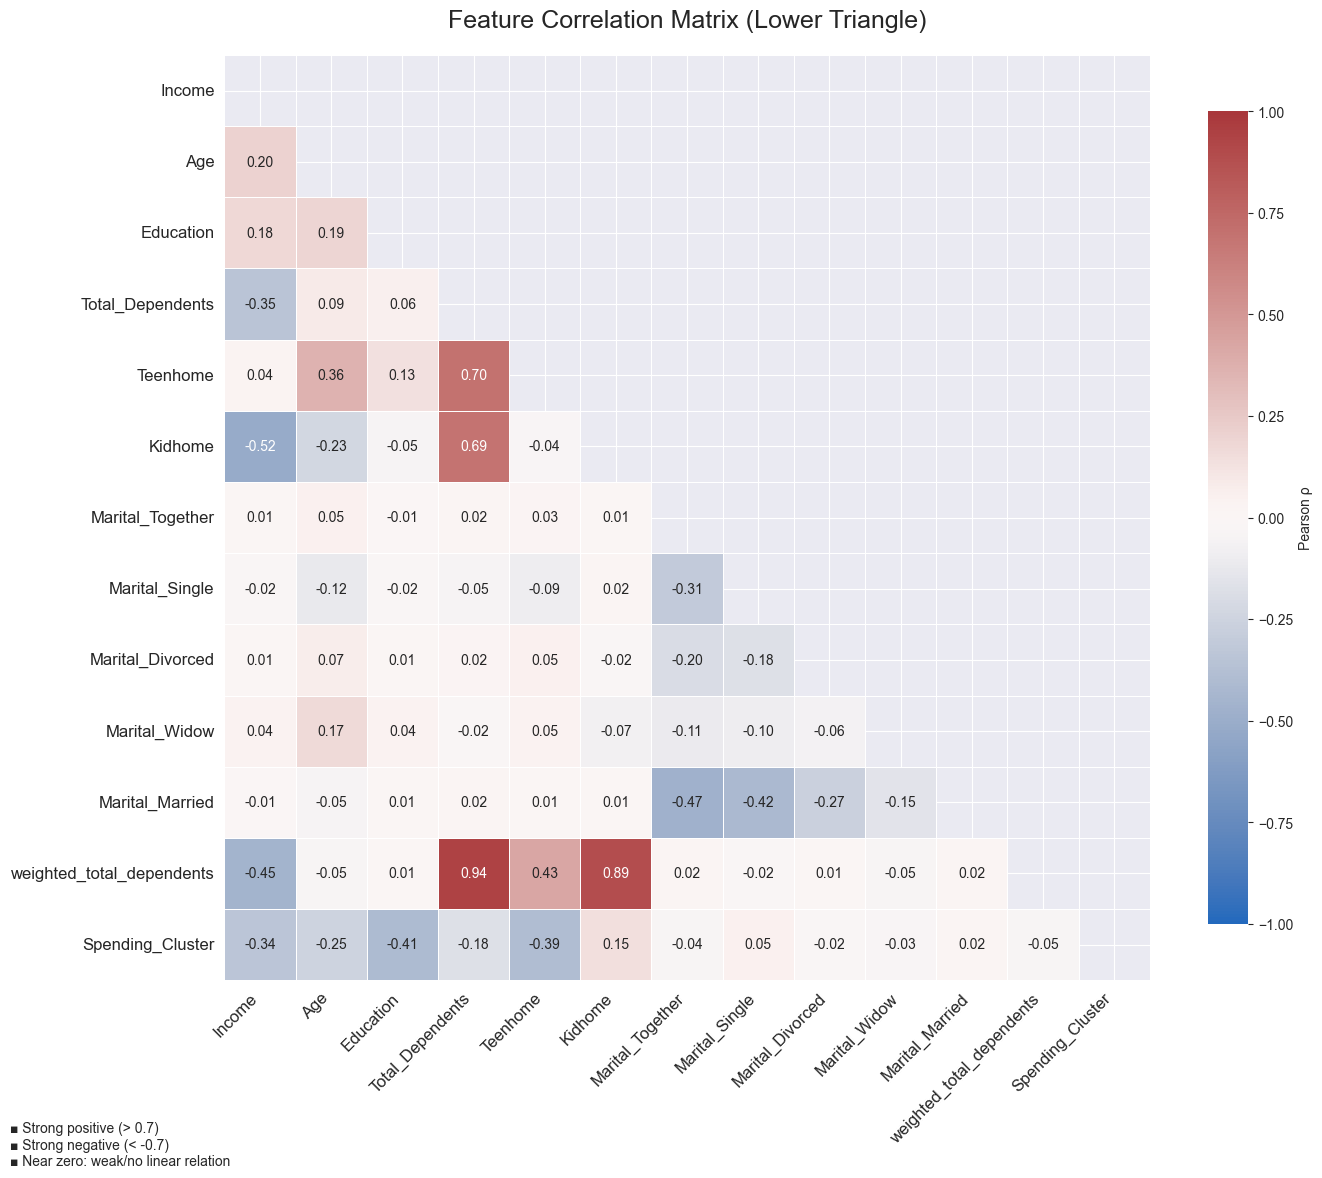

In [33]:
# 2. Correlation Plot Visualization
corr_features = [
    'Income', 'Age', 'Education', 'Total_Dependents', 'Teenhome', 'Kidhome',
    'Marital_Together', 'Marital_Single', 'Marital_Divorced', 'Marital_Widow', 'Marital_Married',
    'weighted_total_dependents', 'Spending_Cluster'
]
if 'weighted_total_dependents' not in df.columns:
    df['weighted_total_dependents'] = df['Kidhome'] * 2 + df['Teenhome']

corr = df[corr_features].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(14, 12))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt='.2f',
    linewidths=.5,
    square=True,
    cbar_kws={'shrink': .8, 'label': 'Pearson ρ'},
    vmin=-1, vmax=1,
    center=0,
    cmap='vlag'
)
plt.title('Feature Correlation Matrix (Lower Triangle)', fontsize=18, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.gcf().text(
    0.01, 0.01,
    "■ Strong positive (> 0.7)\n■ Strong negative (< -0.7)\n■ Near zero: weak/no linear relation",
    fontsize=10,
    bbox=dict(facecolor='white', alpha=0.8)
)
plt.tight_layout()
plt.show()


In [34]:
# 3. Feature Sets
feature_sets = {
    'v1': ['Income', 'Age', 'Education', 'Total_Dependents'],
    'v2': ['Income', 'Age', 'Education', 'Teenhome', 'Kidhome'],
    'v3': ['Income', 'Age', 'Education',
           'Marital_Together', 'Marital_Single', 'Marital_Divorced', 'Marital_Widow', 'Marital_Married',
           'Total_Dependents'],
    'v4': ['Income', 'Age', 'Education', 'Kidhome'],
    'v5': ['Income', 'Age', 'Education', 'weighted_total_dependents']
}

y = df['Spending_Cluster']


In [35]:
# 4. Model Evaluation Loop
param_grid_rf = {
    'n_estimators': [100, 300],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []

for variant, feats in feature_sets.items():
    print(f"\n=== Variant: {variant} | Features: {feats} ===")
    X = df[feats]
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    # Logistic Regression
    grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=kf, scoring='accuracy', n_jobs=-1)
    grid_lr.fit(X_train_s, y_train)
    best_lr = grid_lr.best_estimator_
    lr_preds = best_lr.predict(X_test_s)
    lr_acc = accuracy_score(y_test, lr_preds) * 100
    lr_cv_acc = cross_val_score(best_lr, scaler.fit_transform(X), y, scoring='accuracy', cv=kf)
    print(f"LogisticRegression CV Accuracy: {lr_cv_acc.mean() * 100:.2f}% ± {lr_cv_acc.std() * 100:.2f}%")
    print(f"LogisticRegression Test Accuracy: {lr_acc:.2f}%")
    print("Best LR Params:", grid_lr.best_params_)
    print("Confusion Matrix (LR):\n", confusion_matrix(y_test, lr_preds))

    # Random Forest
    grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=kf, scoring='accuracy', n_jobs=-1)
    grid_rf.fit(X_train_s, y_train)
    best_rf = grid_rf.best_estimator_
    rf_preds = best_rf.predict(X_test_s)
    rf_acc = accuracy_score(y_test, rf_preds) * 100
    rf_cv_acc = cross_val_score(best_rf, scaler.fit_transform(X), y, scoring='accuracy', cv=kf)
    print(f"RandomForest CV Accuracy: {rf_cv_acc.mean() * 100:.2f}% ± {rf_cv_acc.std() * 100:.2f}%")
    print(f"RandomForest Test Accuracy: {rf_acc:.2f}%")
    print("Best RF Params:", grid_rf.best_params_)
    print("Confusion Matrix (RF):\n", confusion_matrix(y_test, rf_preds))

    results.append({
        'Variant': variant,
        'LR_CV_Acc': lr_cv_acc.mean() * 100,
        'LR_Test_Acc': lr_acc,
        'RF_CV_Acc': rf_cv_acc.mean() * 100,
        'RF_Test_Acc': rf_acc
    })



=== Variant: v1 | Features: ['Income', 'Age', 'Education', 'Total_Dependents'] ===
LogisticRegression CV Accuracy: 60.62% ± 1.84%
LogisticRegression Test Accuracy: 61.61%
Best LR Params: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Confusion Matrix (LR):
 [[123  51   4]
 [ 62 100  25]
 [ 14  16  53]]
RandomForest CV Accuracy: 64.38% ± 1.04%
RandomForest Test Accuracy: 64.96%
Best RF Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Confusion Matrix (RF):
 [[124  50   4]
 [ 51 118  18]
 [ 14  20  49]]

=== Variant: v2 | Features: ['Income', 'Age', 'Education', 'Teenhome', 'Kidhome'] ===
LogisticRegression CV Accuracy: 63.08% ± 1.40%
LogisticRegression Test Accuracy: 64.51%
Best LR Params: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Confusion Matrix (LR):
 [[133  42   3]
 [ 59 106  22]
 [ 13  20  50]]
RandomForest CV Accuracy: 64.60% ± 2.15%
RandomForest Test Accuracy: 64.06%
Best RF Params: {'max_depth': 10, 'min_samples_leaf': 2, 'm

In [36]:
# 5. Results Summary
results_df = pd.DataFrame(results)
print("\n=== Summary of All Variants ===")
print(results_df)



=== Summary of All Variants ===
  Variant  LR_CV_Acc  LR_Test_Acc  RF_CV_Acc  RF_Test_Acc
0      v1  60.625000    61.607143  64.375000    64.955357
1      v2  63.080357    64.508929  64.598214    64.062500
2      v3  60.535714    59.598214  65.312500    67.857143
3      v4  57.500000    58.705357  63.437500    64.285714
4      v5  58.750000    58.928571  65.267857    64.732143


In [37]:
# 6. Save Best Model (example: best RF from v3)
best_variant = 'v3'
X = df[feature_sets[best_variant]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
best_rf = RandomForestClassifier(**grid_rf.best_params_, random_state=42)
best_rf.fit(X_scaled, y)

os.makedirs('model', exist_ok=True)
joblib.dump(best_rf, 'model/spending_rf_v3_model.joblib')
joblib.dump(scaler, 'model/spending_scaler_v3.joblib')

print(f"Best model and scaler for {best_variant} saved.")


Best model and scaler for v3 saved.


In [38]:
 # metat